# Module: latticevectors

This module contains functions related to determining the lattice vectors, and making use of them in subsequent calculations.  This includes obtaining an initial guess at the lattice vectors, calculating refined fits to the lattice vectors at each diffraction pattern, strain mapping, and orientation mapping.

## Submodule: strain

In this notebook we demo calculating the infinitessimal strain matrix from the lattice vectors at each scan position.  We proceed as follows:

* Specify a reference region
* Calculate the strain

The strain calculation can be performed either by directly passing the relevant function the reference lattice vectors, or by passing a mask indicating a region from which to find the reference lattice vectors.  Both are shown here.

The relevant mathematics can be found at the end of this notebook.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from scipy.signal import medfilt

from py4DSTEM.file.datastructure import RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import get_reference_uv, get_strain_from_reference_uv, get_strain_from_reference_region

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_shiftcorrected_ellipsecorrectedDiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffraction_shifts                  RealSlice           
   5    strain_map                          RealSlice           
   6    uv_map                              RealSlice           
   7    lattice_vectors                     PointList           
   8    braggpeaks                          PointListArray      
   9    braggpeaks_shifted_ellipticalcorrectedPointListArray      


In [3]:
# Load data

dc = browser.get_dataobject('datacube')
uv_map = browser.get_dataobject('uv_map')
browser.close()

### Specify a reference region 

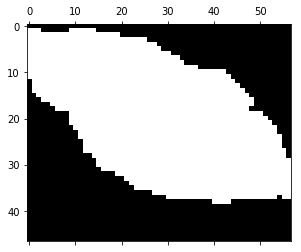

In [4]:
# Here, we simply use all positions where lattice vectors were calculated

mask = uv_map.slices['mask'].astype(bool)

fig,ax = plt.subplots()
ax.matshow(mask,cmap='gray')
plt.show()

### Calculate strain from reference lattice vectors

In [5]:
# Get the reference lattice vectors

ux,uy,vx,vy = get_reference_uv(mask, uv_map)

In [6]:
# Calculate strain

strain_map = get_strain_from_reference_uv(ux,uy,vx,vy,uv_map)

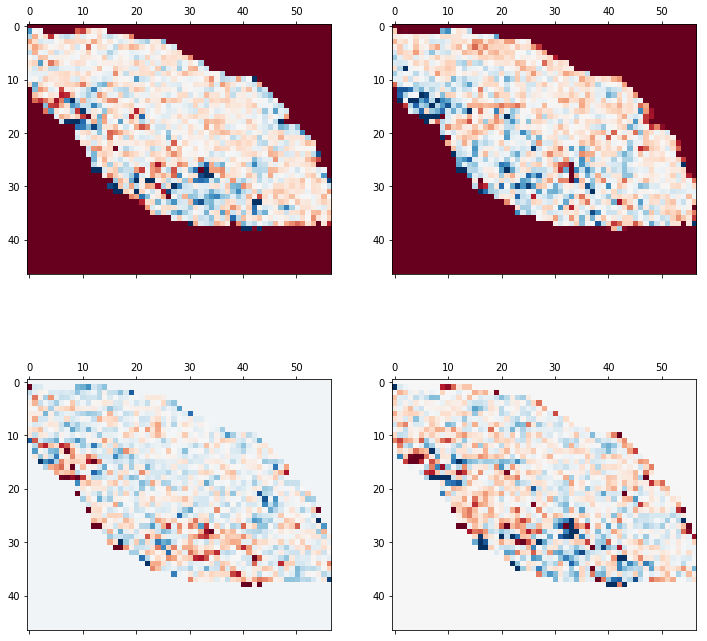

In [13]:
# Show

nstd = 2.5  # Sets display color range

# Set display color scales
e_xx_ave, e_xx_std = np.average(strain_map.slices['e_xx'][mask]),np.std(strain_map.slices['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_map.slices['e_yy'][mask]),np.std(strain_map.slices['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_map.slices['e_xy'][mask]),np.std(strain_map.slices['e_xy'][mask])
theta_ave, theta_std = np.average(strain_map.slices['theta'][mask]),np.std(strain_map.slices['theta'][mask])
e_xx_range = [e_xx_ave-nstd*e_xx_std,e_xx_ave+nstd*e_xx_std]
e_yy_range = [e_yy_ave-nstd*e_yy_std,e_yy_ave+nstd*e_yy_std]
e_xy_range = [e_xy_ave-nstd*e_xy_std,e_xy_ave+nstd*e_xy_std]
theta_range = [theta_ave-nstd*theta_std,theta_ave+nstd*theta_std]

# Plot
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(strain_map.slices['e_xx'],vmin=e_xx_range[0], vmax=e_xx_range[1], cmap="RdBu_r")
ax12.matshow(strain_map.slices['e_yy'],vmin=e_yy_range[0], vmax=e_yy_range[1], cmap="RdBu_r")
ax21.matshow(strain_map.slices['e_xy'],vmin=e_xy_range[0], vmax=e_xy_range[1], cmap="RdBu_r")
ax22.matshow(strain_map.slices['theta'],vmin=theta_range[0], vmax=theta_range[1], cmap="RdBu_r")
plt.show()

### Calculate strain from reference region

In [16]:
# Calculate strain

strain_map = get_strain_from_reference_region(mask,uv_map)

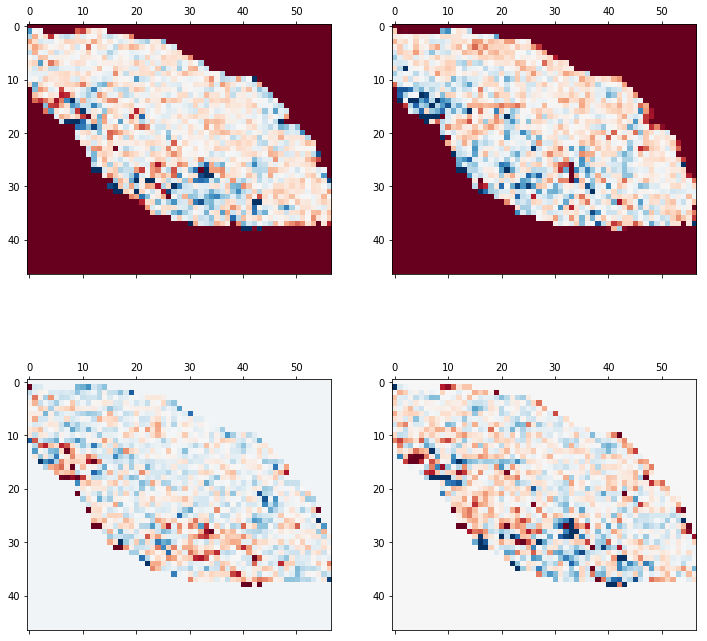

In [17]:
# Show

nstd = 2.5  # Sets display color range

# Set display color scales
e_xx_ave, e_xx_std = np.average(strain_map.slices['e_xx'][mask]),np.std(strain_map.slices['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_map.slices['e_yy'][mask]),np.std(strain_map.slices['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_map.slices['e_xy'][mask]),np.std(strain_map.slices['e_xy'][mask])
theta_ave, theta_std = np.average(strain_map.slices['theta'][mask]),np.std(strain_map.slices['theta'][mask])
e_xx_range = [e_xx_ave-nstd*e_xx_std,e_xx_ave+nstd*e_xx_std]
e_yy_range = [e_yy_ave-nstd*e_yy_std,e_yy_ave+nstd*e_yy_std]
e_xy_range = [e_xy_ave-nstd*e_xy_std,e_xy_ave+nstd*e_xy_std]
theta_range = [theta_ave-nstd*theta_std,theta_ave+nstd*theta_std]

# Plot
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(strain_map.slices['e_xx'],vmin=e_xx_range[0], vmax=e_xx_range[1], cmap="RdBu_r")
ax12.matshow(strain_map.slices['e_yy'],vmin=e_yy_range[0], vmax=e_yy_range[1], cmap="RdBu_r")
ax21.matshow(strain_map.slices['e_xy'],vmin=e_xy_range[0], vmax=e_xy_range[1], cmap="RdBu_r")
ax22.matshow(strain_map.slices['theta'],vmin=theta_range[0], vmax=theta_range[1], cmap="RdBu_r")
plt.show()

## Relevant mathematics

We can write a pair of lattice vectors $\mathbf{u'},\mathbf{v'}$ which have been distorted some amount relative to a pair of undistorted, reference lattice vectors $\mathbf{u},\mathbf{v}$ as a linear transformation:

\begin{align}
\begin{pmatrix}
u_x'   &   v_x'   \\
u_y'   &   v_y'
\end{pmatrix}
&=
\begin{pmatrix}
a  &   b   \\
c  &   d
\end{pmatrix}
\begin{pmatrix}
u_x   &   v_x   \\
u_y   &   v_y
\end{pmatrix}  \\
\end{align}

Here, the effect of $a$ and $d$ is stretching or compression along the $x$ and $y$ directions, respectively, while the effect of $c$ and $d$ is shearing.  Below we denote this as $\beta = A\beta_0$, where $\beta$ and $\beta_0$ are the final and reference lattice vector matrices, respectively, and $A$ is the transformation matrix.  Note that to use numpy.linalg.lstsq to solve for $T$, we'll rearrange this to $\beta = \beta_0^TA^T$.